In [122]:
import pandas as pd
import numpy as np
import scipy.sparse as ss

import pickle
from collections import Counter
from pprint import pprint

import re
import string

import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import spacy
from spacy import displacy
from spacy.symbols import amod
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

import scattertext as st

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.sklearn


from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Get Data

In [2]:
with open('ted_video_transcripts_2416.pkl', 'rb') as picklefile:
    talks = pickle.load(picklefile)

In [3]:
with open('ted_video_stats_2722.pkl', 'rb') as picklefile:
    stats = pickle.load(picklefile)

In [4]:
talks.head(2)

,video_id,transcript
0,YgAuFqEs6yk,[{'text': 'I remember watching my father raise...
1,bNmRr-BYnxA,[{'text': 'Transcriber: Joseph Geni Reviewer: ...


In [5]:
len(talks)

2416

In [6]:
stats.head(2)

,video_id,tags,title,publushed_date,comments_count,dislike_count,like_count,views_count,today,days_age,views_per_day,dislike_perc_of_likes,success,prime_tag
0,Bb7kz1THJPU,"[Science Fiction, Future, Creativity, Society,...","Go ahead, dream about the future | Charlie Jan...",2020-04-20 13:28:47,653,846,2082,71384,2020-05-16,25,2855.360000,40.634006,no,Science Fiction
0,cTIUiN6inIQ,"[The Way We Work, work]",How to make faster decisions | The Way We Work...,2020-02-10 15:00:24,98,84,4298,145314,2020-05-16,95,1529.621053,1.954397,yes,The Way We Work


In [7]:
len(stats)

2722

# Text Preprocessing

### Formatting

In [8]:
def clean_transcript(dirty_line):
    output = ''
    for el in dirty_line: #df['transcript'].values[0]
        for key, value in el.items():
            line_output = str.join("", value)
            output += " " 
            output += line_output
    return output

In [9]:
talks['transcript'] = talks['transcript'].map(clean_transcript)

### SpaCy

In [10]:
nlp = spacy.load('en')

In [11]:
len(STOP_WORDS)

326

Topic  0
say, come, time, feel, tell, story, life, ve, year, love, day, right, think, start

Topic  1
woman, man, girl, work, sex, gender, tell, female, need, boy, change, young, male, story

Topic  2
people, thing, mean, need, right, help, ve, social, community, change, person, live, work, feel

Topic  3
brain, human, different, neuron, right, change, body, time, light, turn, cell, study, control, let

Topic  4
cell, cancer, patient, disease, drug, health, care, blood, heart, doctor, year, need, body, medical

Topic  5
sleep, sort, night, time, ve, try, hour, bed, brain, start, day, need, feel, health

Topic  6
child, school, kid, family, year, work, parent, life, learn, community, help, education, girl, student

Topic  7
work, time, thing, need, ve, new, start, idea, use, technology, create, build, little, right

Topic  8
water, year, planet, city, earth, life, ocean, time, change, ve, place, live, energy, need

Topic  9
country, year, government, need, china, percent, change, global, today, power, problem, right, company, question

In [12]:
my_stop_words_list = ['Transcriber', 'Translator', 'reviewer', 'thanks', 'thank', '\n',
                     'applause','music', 'Laughter', 'applaud', 'TED', 'applause', 'TED Talks',
                     'TED workshop', 'Elizabeth',  'Gilbert', 'Ivana', 'Korom','Krystian', 'Aparta', 'Walters',
                     'Joseph','Geni', 'thing', 'think', 'know', 'like', 'way', 'look', 'lot', 'good', 'bad', 'want', 'kind', 
                     'talk', 'word', 'actually', 'hi', 'woman', 'man', 
                      'people', 'say', 'come', 'feel', 'tell','ve', 'day', 'right','think',
                     '']
for word in my_stop_words_list:
    spacy.lang.en.stop_words.STOP_WORDS.add(word)
    nlp.vocab[word].is_stop = True

In [13]:
#STOP_WORDS

In [14]:
persons = []
for i in range(talks.shape[0]):
    persons.append([ent.text for ent in nlp(talks['transcript'][i]).ents if ent.label_ == 'PERSON'])

In [15]:
#persons

In [16]:
persons_flat_list = [item for sublist in persons for item in sublist]

In [17]:
#persons_flat_list

In [18]:
persons_flat_list = str(persons_flat_list).replace("'", '').replace(",", '').replace(":", '').replace("[", '').split()

In [19]:
errors = ['Parenthood', 'Mamas', 'corona','misstep', 'monk', 'moon', 'Paris', 'attach kid', 'Berlin 2005', 
          'butterfly', 'Xbox', 'Uber Lyft', 'Crisis Text Line', 'God', 'Law', 'Moon', 'Sun', 'microphone hiss',
          'sanitary napkin', 'hygiene piece', 'hygiene piece', 'downright macabre','berlin',
          'applaud african', 'diaspora hear', 'politician mirror', 'bradfeld', 'carrier asymptomatic',
          'New Yorker', 'yank mouth', 'metaphor monk', 'Facebook', 'LEGOs lego', 'lot hubris','healthy leafy green',
          'hygiene factor', 'healthy melatonin', 'lover gentle', 'mosquito','Gmail','iCloud Apple',
          'Kaspersky', 'bomb satsang wood', 'kiosk', 'intro', 'sama buona ICU', 'need belong','thousand',
          'snooze button', 'primarily white', 'gnash throat', 'fangirl learn', 'Xbox PlayStation', 'butterfly']

In [20]:
persons_flat_list = persons_flat_list
for i in persons_flat_list:
    if i in errors:
       # print(i)
        persons_flat_list.remove(i)

In [21]:
#persons_flat_list

In [22]:
for word in persons_flat_list:
    spacy.lang.en.stop_words.STOP_WORDS.add(word)
    nlp.vocab[word].is_stop = True

In [93]:
nlp.vocab['woman'].is_stop

True

In [24]:
##########talks = talks.iloc[:50, :]

In [25]:
talks.head(6)

,video_id,transcript
0,YgAuFqEs6yk,I remember watching my father raised the pist...
1,bNmRr-BYnxA,Transcriber: Joseph Geni\nReviewer: Camille M...
2,FVUkKKc3Vvk,"Hi, everyone, my name is Elizabeth, and I wor..."
3,8bj0GR34XWc,Transcriber: Ivana Korom\nReviewer: Krystian ...
4,eaCrsBtiYA4,I am a public policy wonk. I investigate data...
5,OMDVTZ-ycaY,Transcriber: Joseph Geni\nReviewer: Joanna Pi...


In [26]:
talks['transcript1'] = talks.transcript.apply(
    lambda text: ' '.join(token.orth_ for token in nlp(text) if not token.is_punct))

In [27]:
talks['transcript2'] = talks.transcript1.apply(
    lambda text: ' '.join(token.lemma_ for token in nlp(text) if not token.is_stop))

In [28]:
talks['transcript2'] = talks['transcript2'].apply(lambda text: re.sub('\n', '', text))

In [29]:
talks['transcript'] = talks['transcript2']

In [30]:
talks.drop(['transcript1', 'transcript2'], inplace=True, axis=1)

In [31]:
talks['transcript'] = talks['transcript'].apply(lambda text: re.sub(r'\b[0-9]+\b\W*', '', text))

In [32]:
#stemmer=LancasterStemmer()
#porter=PorterStemmer()

In [33]:
# #englishStemmer=SnowballStemmer("english", ignore_stopwords=True)
# def stemComment(comment_line):
#     token_words=word_tokenize(comment_line)
#     stem_line=[]
#     for word in token_words:
#         stem_line.append(englishStemmer.stem(word))
#         stem_line.append(" ")
#     return "".join(stem_line)

In [34]:
# stop_words = set(stopwords.words('english'))

# def remove_stop_words(comment_line):
#     token_words=word_tokenize(str(comment_line))
#     filtered_comment_line = [w for w in token_words if not w in stop_words] 
    
#     return " ".join(filtered_comment_line)

In [35]:
#alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
#punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

In [36]:
# df['transcript'] = df['transcript'].map(remove_stop_words).map(alphanumeric).map(punc_lower)

In [37]:
# #https://stackoverflow.com/questions/29270917/removing-custom-stop-words-form-a-phrase-in-python
# my_stop_words_lst = ['ted', 'text', 'thank', 'you']

# for w in my_stop_words_lst:
#     pattern = r'\b'+w+r'\b'
#     custom_stop = lambda x: re.sub(pattern, ' ', x)
#     df['transcript'] = df['transcript'].map(custom_stop)

In [38]:
# df['transcript'] = df['transcript'].map(stemComment)

### Plarity scores addition 

In [39]:
analyser = SentimentIntensityAnalyzer()
def extract_polarity(text, polarity_type = 'neg'):
    all_val = analyser.polarity_scores(text)
    return all_val[polarity_type]
    

In [40]:
#extract_polarity(talks['transcript'].values[0], polarity_type = 'neg')

In [41]:
talks['polarity_neg_transcript'] = talks['transcript'].map(extract_polarity)
talks['polarity_pos_transcript'] = talks['transcript'].apply(extract_polarity, polarity_type = 'pos')
talks['polarity_neu_transcript'] = talks['transcript'].apply(extract_polarity, polarity_type = 'neu')
talks['polarity_compound_transcript'] = talks['transcript'].apply(extract_polarity, polarity_type = 'compound')

# EDA 

### Scattertext

In [42]:
df1 = pd.merge(talks, stats,  how='left', left_on='video_id', right_on = 'video_id')

In [43]:
#df1

In [44]:
 corpus = st.CorpusFromPandas(df1,
                              category_col='success',
                              text_col='transcript',
                              nlp=st.whitespace_nlp_with_sentences
                             ).build()

In [45]:
 html = st.produce_scattertext_explorer(
         corpus,
         category='yes',
         category_name='Likable',
         not_category_name='Dislikable',
         minimum_term_frequency=10,
         pmi_threshold_coefficient=5,
         width_in_pixels=1000,
         #metadata=df1['prime_tag']
         metadata=corpus.get_df()['prime_tag']
         )

In [77]:
open('transcripts_0518.html', 'wb').write(html.encode('utf-8'));

In [76]:
!pwd

/Users/elena/Desktop/Metis/Project_4_Ted/Project-4-Ted


### LDA PyViz

In [47]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=1000,                # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(talks.transcript)

In [48]:
n_components = 7

lda_model = LatentDirichletAllocation(n_components=n_components,   # Number of topics
                                      max_iter=10,                 # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,            # Random state
                                      #batch_size=128,             # n docs in each learning iter
                                      n_jobs = -1,                 # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [49]:
pyLDAvis.enable_notebook()

panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer)
panel

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.058469  0.012170       1        1  23.780393
1      0.107484 -0.070652       2        1  17.280458
2     -0.092366  0.005491       3        1  14.906867
4      0.034753 -0.053973       4        1  14.313169
0     -0.083885 -0.075605       5        1  12.182128
5      0.059797  0.127075       6        1   8.814261
6     -0.084252  0.055495       7        1   8.722724, topic_info=    Category         Freq     Term        Total  loglift  logprob
90   Default  2645.000000    brain  2645.000000  30.0000  30.0000
117  Default  1966.000000     cell  1966.000000  29.0000  29.0000
982  Default  3246.000000    woman  3246.000000  28.0000  28.0000
966  Default  2387.000000    water  2387.000000  27.0000  27.0000
187  Default  3715.000000  country  3715.000000  26.0000  26.0000
..       ...          ...      ...          ...      ...      ...
520   Topic7   464.416300     look  4212.324951   0.2342  -5.2092
585   Topic7   506.008304     need  7929.744541  -0.3126  -5.1234
500   Topic7   467.107822      let  4784.631760   0.1126  -5.2034
847   Topic7   457.365266    start  6768.382623  -0.2553  -5.2245
689   Topic7   442.155238  problem  3946.007760   0.2504  -5.2583

[421 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         1  0.132840   able
1         2  0.140105   able
1         3  0.265335   able
1         4  0.069534   able
1         5  0.113468   able
...     ...       ...    ...
997       3  0.005665  young
997       4  0.005665  young
997       5  0.011897  young
997       6  0.093477  young
997       7  0.018129  young

[1848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1, 6, 7])

# Topic Modeling

In [50]:
def display_topics(model, feature_names, no_top_words, model_type = 'lsa_nmf_lda', topic_names=None):
    if model_type == 'lsa_nmf_lda':
        for ix, topic in enumerate(model.components_):
            if not topic_names or not topic_names[ix]:
                print("\nTopic ", ix)
            else:
                print("\nTopic: '",topic_names[ix],"'")
            print(", ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]]))
    elif model_type == 'corex':
        for ix, topic in enumerate(model.alpha):
            if not topic_names or not topic_names[ix]:
                print("\nTopic ", ix)
            else:
                print("\nTopic: '",topic_names[ix],"'")
            print(", ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]]))
    else:
        raise ValueError('Unknown model type')

### Text transformation

TF_IDF

In [51]:
vectorizer_TF_IDF = TfidfVectorizer(stop_words='english', max_df=1.0, min_df=2, strip_accents='ascii') 
doc_word_TF_IDF = vectorizer_TF_IDF.fit_transform(list(talks.transcript))

In [52]:
pd.DataFrame(doc_word_TF_IDF.toarray(), columns=vectorizer_TF_IDF.get_feature_names()).shape

(2416, 21028)

In [53]:
dtm_TF_IDF = pd.DataFrame(doc_word_TF_IDF.toarray(), index=talks['video_id'], columns=vectorizer_TF_IDF.get_feature_names())
words_TF_IDF = list(np.asarray(vectorizer_TF_IDF.get_feature_names()))

Basic (for LDA)

In [54]:
vectorizer = CountVectorizer(stop_words='english', max_df=1.0, min_df=2, strip_accents='ascii') 
doc_word = vectorizer.fit_transform(list(talks.transcript))

In [55]:
pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names()).shape

(2416, 21028)

In [78]:
dtm = pd.DataFrame(doc_word.toarray(), index=talks['video_id'], columns=vectorizer.get_feature_names())
words = list(np.asarray(vectorizer.get_feature_names()))

### LSA

In [57]:
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(dtm_TF_IDF)
lsa.explained_variance_ratio_

array([0.00460511, 0.00921056, 0.00708684, 0.00659364, 0.00592604,
       0.00527995, 0.00476502, 0.00452409, 0.00413747, 0.00398506])

In [58]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5",
                     "component_6","component_7", "component_8","component_9", "component_10"],
             columns = vectorizer_TF_IDF.get_feature_names())
topic_word

,000th,0s,1000th,100th,10th,10x,11th,12th,130th,13th,...,zoo,zoologist,zoology,zoom,zoonotic,zoop,zoos,zuccotti,zurich,zygote
component_1,0.000,0.000,0.0,0.001,0.001,0.000,0.002,0.002,0.000,0.001,...,0.002,0.000,0.000,0.006,0.000,0.000,0.000,0.000,0.001,0.000
component_2,-0.000,-0.000,-0.0,0.000,0.001,-0.000,0.001,0.000,-0.000,0.001,...,-0.002,0.000,-0.001,-0.013,-0.001,0.000,-0.000,0.000,-0.001,-0.000
component_3,0.001,0.000,-0.0,-0.001,-0.001,-0.000,-0.000,-0.001,0.000,0.000,...,0.002,0.000,-0.000,0.005,-0.000,0.000,0.000,-0.001,0.000,-0.000
component_4,0.001,-0.001,0.0,-0.001,-0.003,0.000,-0.002,-0.003,-0.001,-0.002,...,0.003,-0.000,-0.000,-0.004,0.002,-0.001,0.000,0.000,-0.001,-0.000
component_5,0.000,-0.000,0.0,0.000,-0.001,-0.000,0.000,-0.002,-0.000,0.000,...,0.005,-0.000,0.001,0.004,-0.000,0.000,0.000,-0.001,-0.000,0.000
component_6,-0.000,0.000,-0.0,-0.000,-0.001,0.000,-0.000,-0.000,0.000,-0.001,...,-0.001,-0.001,-0.000,0.006,-0.001,-0.000,0.000,0.000,0.001,-0.000
component_7,0.000,0.001,-0.0,-0.001,0.003,0.000,-0.001,-0.001,0.000,-0.001,...,-0.002,0.000,-0.000,0.001,-0.001,-0.000,-0.001,-0.000,0.003,0.001
component_8,-0.000,0.001,-0.0,-0.001,-0.004,0.000,-0.003,-0.002,-0.000,-0.001,...,0.001,0.001,0.000,-0.001,0.000,-0.000,0.000,-0.001,0.001,-0.001
component_9,-0.000,-0.000,-0.0,0.000,0.001,-0.000,0.001,0.002,-0.000,-0.000,...,-0.002,0.000,-0.000,0.010,-0.000,-0.000,0.000,0.001,-0.002,0.000
component_10,-0.001,-0.000,0.0,0.001,-0.000,-0.001,0.001,-0.001,-0.000,-0.000,...,0.004,0.000,-0.000,-0.010,0.000,0.000,0.001,0.001,0.003,0.000


In [59]:
display_topics(lsa, vectorizer_TF_IDF.get_feature_names(), 15)


Topic  0
year, time, work, say, need, life, thing, woman, start, change, child, story, new, come, country

Topic  1
woman, girl, child, man, school, say, family, kid, parent, young, father, boy, education, community, violence

Topic  2
brain, cell, cancer, patient, disease, body, drug, doctor, neuron, blood, gene, heart, sleep, medical, tumor

Topic  3
cell, patient, woman, cancer, health, disease, drug, country, care, doctor, percent, medical, treatment, medicine, climate

Topic  4
woman, water, planet, ocean, earth, man, fish, girl, light, mars, sea, star, climate, animal, life

Topic  5
woman, man, robot, sex, gender, company, female, datum, ai, computer, machine, technology, human, medium, male

Topic  6
city, robot, woman, design, building, school, build, girl, cell, community, space, architecture, material, student, education

Topic  7
robot, school, child, kid, student, teacher, education, girl, planet, ocean, ai, fish, brain, learn, parent

Topic  8
brain, cell, school, neuron

In [60]:
len(lsa.components_)

10

In [61]:
doc_topic_lsa = pd.DataFrame(doc_topic,
                             index=talks['video_id'],
                             columns = ["component_1","component_2", "component_3","component_4", "component_5", 
                                       "component_6","component_7", "component_8","component_9", "component_10"])
doc_topic_lsa

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
video_id,,,,,,,,,,
YgAuFqEs6yk,0.290546,0.126347,0.066769,-0.110128,0.061200,-0.102860,-0.035483,-0.001948,-0.024002,0.005860
bNmRr-BYnxA,0.298731,-0.004782,-0.053198,0.009591,0.011373,-0.012934,-0.099654,-0.049492,-0.007796,0.073339
FVUkKKc3Vvk,0.288862,0.111245,-0.002842,-0.041213,-0.002242,-0.102692,-0.016193,0.039610,0.014092,0.015848
8bj0GR34XWc,0.203993,-0.054633,0.046567,0.108288,-0.033108,-0.023719,-0.059774,-0.038095,-0.035839,-0.005831
eaCrsBtiYA4,0.278426,0.076299,-0.105606,0.060204,-0.038819,-0.022705,-0.021578,-0.028425,0.002973,0.021638
...,...,...,...,...,...,...,...,...,...,...
HUM2rCIUdeI,0.219337,0.023790,-0.084846,0.043275,-0.015199,-0.012524,-0.025810,0.024331,0.007646,0.006154
C_SBGTJgBGo,0.149880,0.017480,0.040330,-0.061703,0.008803,-0.014187,-0.013851,-0.059987,-0.002608,0.018441
MLU7qcMYKO8,0.131781,-0.139848,-0.075295,-0.014136,0.200072,0.006916,-0.048672,0.096540,-0.094623,-0.081554


In [62]:
cosine_similarity((doc_topic_lsa.values[0], 
                   doc_topic_lsa.values[1], 
                   doc_topic_lsa.values[3],  
                   doc_topic_lsa.values[4], 
                   doc_topic_lsa.values[5], 
                   doc_topic_lsa.values[6]))

array([[1.        , 0.72493233, 0.49931243, 0.66696167, 0.56120759,
        0.17384422],
       [0.72493233, 1.        , 0.78683829, 0.88647099, 0.59543941,
        0.30587155],
       [0.49931243, 0.78683829, 1.        , 0.70699235, 0.67834837,
        0.59288911],
       [0.66696167, 0.88647099, 0.70699235, 1.        , 0.51862411,
        0.19812914],
       [0.56120759, 0.59543941, 0.67834837, 0.51862411, 1.        ,
        0.72288199],
       [0.17384422, 0.30587155, 0.59288911, 0.19812914, 0.72288199,
        1.        ]])

### NMF (Non-Negative Matrix Factorization)

In [124]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(doc_word)

In [125]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5",
                     "component_6","component_7", "component_8","component_9", "component_10"],
             columns = vectorizer_TF_IDF.get_feature_names())
topic_word

,000th,0s,1000th,100th,10th,10x,11th,12th,130th,13th,...,zoo,zoologist,zoology,zoom,zoonotic,zoop,zoos,zuccotti,zurich,zygote
component_1,0.001,0.004,0.000,0.001,0.007,0.001,0.000,0.008,0.008,0.007,...,0.032,0.001,0.001,0.236,0.000,0.000,0.005,0.000,0.010,0.000
component_2,0.000,0.001,0.000,0.000,0.009,0.000,0.000,0.003,0.000,0.012,...,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002
component_3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.057,...,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_4,0.000,0.000,0.000,0.011,0.001,0.000,0.014,0.007,0.000,0.014,...,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.010,0.001,0.000
component_5,0.007,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.001,0.000,...,0.035,0.000,0.000,0.026,0.009,0.000,0.003,0.000,0.000,0.000
component_6,0.000,0.001,0.004,0.004,0.001,0.002,0.000,0.000,0.000,0.000,...,0.031,0.001,0.008,0.084,0.000,0.000,0.002,0.000,0.001,0.002
component_7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000
component_8,0.000,0.000,0.001,0.000,0.000,0.003,0.010,0.012,0.000,0.000,...,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.001,0.000,0.000
component_9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.003,0.000,0.000,0.119,0.000,0.000,0.001,0.000,0.002,0.000
component_10,0.001,0.000,0.000,0.005,0.012,0.000,0.022,0.012,0.000,0.006,...,0.005,0.000,0.000,0.003,0.000,0.002,0.000,0.000,0.003,0.000


In [127]:
display_topics(nmf_model, vectorizer_TF_IDF.get_feature_names(), 14)


Topic  0
thing, human, new, time, different, use, technology, create, little, idea, computer, design, build, start

Topic  1
child, school, kid, family, year, learn, parent, community, education, life, help, student, girl, old

Topic  2
sleep, sort, night, time, try, bed, hour, brain, start, need, health, thing, asleep, term

Topic  3
country, need, year, government, change, china, percent, global, question, today, mean, problem, happen, power

Topic  4
cell, cancer, patient, disease, drug, health, blood, heart, care, year, body, doctor, human, life

Topic  5
water, year, planet, earth, time, ocean, life, city, change, energy, need, climate, place, live

Topic  6
woman, man, girl, sex, gender, female, work, young, change, need, male, boy, issue, story

Topic  7
work, need, time, company, thing, start, help, job, try, vaccine, mean, team, hour, ask

Topic  8
brain, neuron, change, time, different, area, study, turn, light, human, body, control, cell, experience

Topic  9
say, time, lif

In [128]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index=talks['video_id'],
                             columns = ["component_1","component_2", "component_3","component_4", "component_5",
                                       "component_6","component_7", "component_8","component_9", "component_10"])
doc_topic_nmf

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
video_id,,,,,,,,,,
YgAuFqEs6yk,0.02162,0.39863,0.01701,0.00000,0.00000,0.04276,0.00476,0.25204,0.00000,0.75114
bNmRr-BYnxA,0.11369,0.00298,0.00000,0.45552,0.00000,0.34156,0.00000,0.30398,0.19768,0.69095
FVUkKKc3Vvk,0.15219,0.56325,0.01444,0.07940,0.01853,0.04845,0.00000,0.10670,0.00000,0.35764
8bj0GR34XWc,0.10663,0.00000,0.03983,0.52110,0.48113,0.00000,0.00000,0.30777,0.03589,0.19387
eaCrsBtiYA4,0.03154,0.22062,0.00000,0.39815,0.01736,0.04775,0.12533,0.00000,0.00000,0.40287
...,...,...,...,...,...,...,...,...,...,...
HUM2rCIUdeI,0.09505,0.32700,0.00000,0.49911,0.00000,0.22039,0.03261,0.49758,0.00000,0.35113
C_SBGTJgBGo,0.04477,0.04787,0.04352,0.01367,0.01170,0.02233,0.03952,0.04092,0.04567,0.19276
MLU7qcMYKO8,0.00000,0.00000,0.00000,0.00000,0.00000,2.03275,0.00000,0.00000,0.03734,0.03557


In [129]:
cosine_similarity((doc_topic_nmf.values[0], 
                   doc_topic_nmf.values[1], 
                   doc_topic_nmf.values[3],  
                   doc_topic_nmf.values[4], 
                   doc_topic_nmf.values[5], 
                   doc_topic_nmf.values[6]))

array([[1.        , 0.71043386, 0.31588082, 0.71104953, 0.32493485,
        0.16117821],
       [0.71043386, 1.        , 0.6175525 , 0.79195008, 0.41266093,
        0.23582554],
       [0.31588082, 0.6175525 , 1.        , 0.59158451, 0.44720451,
        0.71892813],
       [0.71104953, 0.79195008, 0.59158451, 1.        , 0.11831528,
        0.03850648],
       [0.32493485, 0.41266093, 0.44720451, 0.11831528, 1.        ,
        0.64272588],
       [0.16117821, 0.23582554, 0.71892813, 0.03850648, 0.64272588,
        1.        ]])

In [134]:
pairwise_distances(doc_topic[0].reshape(1, -1),doc_topic,metric='cosine').argsort()

array([[   0, 1865, 1457, ..., 1509, 2150,  191]])

### LDA

In [99]:
lda = LatentDirichletAllocation(n_components=10)
doc_topic = lda.fit_transform(dtm)

In [100]:
lda.score

<bound method LatentDirichletAllocation.score of LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)>

In [101]:
topic_word = pd.DataFrame(lda.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5", 
                     "component_6","component_7", "component_8","component_9", "component_10"],
             columns = vectorizer.get_feature_names())
topic_word

,000th,0s,1000th,100th,10th,10x,11th,12th,130th,13th,...,zoo,zoologist,zoology,zoom,zoonotic,zoop,zoos,zuccotti,zurich,zygote
component_1,1.217,2.1,0.1,1.100,0.100,0.1,0.100,0.100,1.1,3.089,...,40.520,0.1,0.1,27.868,0.1,0.1,3.341,0.1,2.040,2.1
component_2,0.100,0.1,0.1,3.430,3.385,0.1,2.394,1.993,0.1,4.277,...,5.442,0.1,0.1,0.100,0.1,0.1,0.100,0.1,0.100,0.1
component_3,0.100,0.1,0.1,0.100,5.902,0.1,3.557,2.893,2.1,5.211,...,0.100,0.1,0.1,21.921,0.1,2.1,0.100,0.1,0.100,0.1
component_4,0.100,0.1,0.1,1.149,0.100,0.1,0.100,0.100,0.1,0.100,...,0.100,0.1,0.1,52.230,0.1,0.1,0.100,0.1,0.100,0.1
component_5,0.100,0.1,0.1,3.980,1.903,0.1,6.099,13.038,0.1,0.100,...,0.105,0.1,0.1,8.868,0.1,0.1,0.100,3.1,0.100,0.1
component_6,1.983,0.1,0.1,0.100,0.100,0.1,0.100,0.100,0.1,0.100,...,0.262,0.1,0.1,0.100,0.1,0.1,0.100,0.1,0.100,0.1
component_7,1.100,0.1,2.1,1.841,0.100,0.1,1.246,0.100,0.1,0.476,...,2.170,2.1,6.1,21.911,0.1,0.1,0.859,0.1,8.853,0.1
component_8,0.100,0.1,0.1,0.100,9.209,2.1,5.509,6.475,0.1,6.447,...,0.100,0.1,0.1,14.141,0.1,0.1,0.100,0.1,3.383,0.1
component_9,0.100,0.1,0.1,0.100,0.100,0.1,1.794,0.100,0.1,0.100,...,0.100,0.1,0.1,3.761,0.1,0.1,0.100,0.1,0.124,0.1
component_10,0.100,0.1,0.1,0.100,0.100,0.1,0.100,0.100,0.1,0.100,...,0.100,0.1,0.1,0.101,6.1,0.1,0.100,0.1,0.100,0.1


In [102]:
display_topics(lda, vectorizer.get_feature_names(), 15)


Topic  0
animal, year, cell, human, time, life, gene, different, specie, study, live, body, little, thing, change

Topic  1
year, child, work, say, time, school, life, woman, need, family, change, start, ask, help, come

Topic  2
city, community, live, need, place, create, time, design, play, build, street, building, space, home, work

Topic  3
brain, cell, planet, light, time, universe, different, energy, little, star, solar, year, thing, sound, use

Topic  4
country, government, year, power, political, story, information, democracy, china, mean, time, internet, today, medium, new

Topic  5
year, water, need, percent, food, climate, change, country, global, energy, grow, plant, ocean, million, problem

Topic  6
time, work, human, year, design, create, build, robot, space, new, use, different, technology, machine, start

Topic  7
work, time, thing, say, start, year, little, need, let, try, mean, idea, think, ask, come

Topic  8
life, say, woman, love, time, story, year, body, live, wo

In [105]:
#doc_topic

In [ ]:
doc_topic_lda = pd.DataFrame(doc_topic.round(5),
                             index=talks['video_id'],
                             columns = ["component_1","component_2", "component_3","component_4", "component_5",
                                       "component_6","component_7", "component_8","component_9", "component_10"])
doc_topic_lda

In [74]:
cosine_similarity((doc_topic_lda.values[0], 
                   doc_topic_lda.values[1], 
                   doc_topic_lda.values[3],  
                   doc_topic_lda.values[4], 
                   doc_topic_lda.values[5], 
                   doc_topic_lda.values[6]))

array([[1.        , 0.46084979, 0.03130093, 0.10284463, 0.2485791 ,
        0.0450461 ],
       [0.46084979, 1.        , 0.56087441, 0.74460207, 0.11715944,
        0.02218972],
       [0.03130093, 0.56087441, 1.        , 0.39477732, 0.28903039,
        0.06423526],
       [0.10284463, 0.74460207, 0.39477732, 1.        , 0.04842789,
        0.03149245],
       [0.2485791 , 0.11715944, 0.28903039, 0.04842789, 1.        ,
        0.28406819],
       [0.0450461 , 0.02218972, 0.06423526, 0.03149245, 0.28406819,
        1.        ]])

# CorEx

In [106]:
corex_model = ct.Corex(n_hidden=10, words=words, seed=1)
doc_topic = corex_model.fit(doc_word_TF_IDF, words=words, docs=talks.transcript)

In [107]:
len(corex_model.alpha[0])

21028

In [108]:
topic_word = pd.DataFrame(corex_model.alpha.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5",
                     "component_6","component_7", "component_8","component_9", "component_10"],
             columns = vectorizer_TF_IDF.get_feature_names())
topic_word

,000th,0s,1000th,100th,10th,10x,11th,12th,130th,13th,...,zoo,zoologist,zoology,zoom,zoonotic,zoop,zoos,zuccotti,zurich,zygote
component_1,0.0,0.0,0.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,1.0,0.0,0.0,1.0
component_2,0.0,0.0,0.0,0.0,0.000,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
component_3,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
component_4,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
component_5,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.000,0.0,0.0,0.0,0.0,1.0,0.0
component_6,0.0,1.0,0.0,0.0,0.000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
component_7,1.0,0.0,0.0,0.0,1.000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,1.0,0.0,0.0,0.0,0.0
component_8,0.0,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
component_9,0.0,0.0,0.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.001,0.0,0.0,0.0,1.0,0.0,0.0
component_10,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,0.0


In [109]:
display_topics(corex_model, vectorizer_TF_IDF.get_feature_names(), 14, model_type = 'corex')


Topic  0
zygote, dioxide, dim, submit, mansion, submersible, dingy, submarine, manipulative, manic, dinosaur, subjectivity, diphtheria, subscription

Topic  1
decimate, cram, reengineer, tint, anthropogenic, kanye, referral, tinge, anthropology, reflector, reformation, redwood, timetable, junkie

Topic  2
radiologist, numerically, oval, beware, overactive, editorial, teenage, overbearing, tedx, edition, ecotourism, overeat, bidirectional, biennial

Topic  3
parchment, nudge, hotshot, hound, daydream, somali, household, somalia, housewife, trustworthiness, dating, somalis, somatic, circulation

Topic  4
memorize, reproducibility, exaggerated, evolutionary, eviction, evasion, respirator, respite, evangelist, responsibilitie, responsibility, responsiveness, restore, resurrect

Topic  5
nfl, anger, stealthy, hug, hugging, ste, humane, stave, humanely, humanist, humanize, humble, cartel, statistic

Topic  6
000th, symmetry, cinematic, taco, plains, hind, circus, hilt, planner, plantation, 

In [83]:
#topic_model.get_topics()

In [84]:
# Print all topics from the CorEx topic model
#topics = topic_model.get_topics()
#for n,topic in enumerate(topics):
#    topic_words,_ = zip(*topic)
#    print('{}: '.format(n) + ','.join(topic_words))

In [85]:
#topics

In [86]:
#key docs associated with a topic
# Let's check out topic : 3
#topic_model.get_top_docs(topic=0, n_docs=1)

In [87]:
#topic_model.labels

In [88]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
#predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(7)])
#predictions.head(3)

In [89]:
#topic_model.p_y_given_x

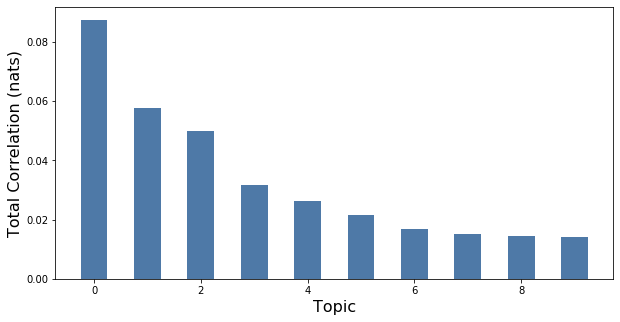

In [92]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_model.tcs.shape[0]), corex_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [117]:
doc_topic_corex = pd.DataFrame(doc_topic.p_y_given_x,
                             index=talks['video_id'],
                             columns = ["component_1","component_2", "component_3","component_4", "component_5",
                                       "component_6","component_7", "component_8","component_9", "component_10"])
doc_topic_corex

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
video_id,,,,,,,,,,
YgAuFqEs6yk,0.000846,0.007371,0.000735,0.007364,0.001978,0.001739,0.000251,0.000016,0.000035,0.000130
bNmRr-BYnxA,0.012498,0.021787,0.001401,0.012618,0.000980,0.000142,0.000480,0.000144,0.000125,0.000318
FVUkKKc3Vvk,0.002018,0.014877,0.001099,0.019476,0.001877,0.000472,0.000203,0.000099,0.000240,0.000855
8bj0GR34XWc,0.008599,0.953999,0.000762,0.012968,0.000745,0.000377,0.000672,0.000261,0.000309,0.000513
eaCrsBtiYA4,0.002461,0.010381,0.000411,0.033791,0.000228,0.001083,0.000443,0.000009,0.000015,0.787954
...,...,...,...,...,...,...,...,...,...,...
HUM2rCIUdeI,0.001344,0.004268,0.000067,0.018594,0.000768,0.001785,0.000114,0.000002,0.000013,0.000222
C_SBGTJgBGo,0.001202,0.021655,0.001728,0.005875,0.242761,0.001183,0.000558,0.000405,0.000195,0.000187
MLU7qcMYKO8,0.141455,0.017833,0.682747,0.006288,0.001969,0.000448,0.000582,0.000777,0.000627,0.000403


In [118]:
 cosine_similarity((doc_topic_corex.values[0], 
                   doc_topic_corex.values[1], 
                   doc_topic_corex.values[3],  
                   doc_topic_corex.values[4], 
                   doc_topic_corex.values[5], 
                   doc_topic_corex.values[6]))

array([[1.        , 0.87851127, 0.69207405, 0.0507144 , 0.73067856,
        0.68824067],
       [0.87851127, 1.        , 0.78355658, 0.04207428, 0.80777869,
        0.78119601],
       [0.69207405, 0.78355658, 1.        , 0.01430849, 0.82266924,
        0.99997954],
       [0.0507144 , 0.04207428, 0.01430849, 1.        , 0.025199  ,
        0.01410662],
       [0.73067856, 0.80777869, 0.82266924, 0.025199  , 1.        ,
        0.82286885],
       [0.68824067, 0.78119601, 0.99997954, 0.01410662, 0.82286885,
        1.        ]])

In [120]:
#topic_model.tcs

In [135]:
#anchoring
topic_model = ct.Corex(n_hidden=5, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=talks.transcript, 
                anchors=[['protein', 'cell'], 
                         ['ocean', 'marine'], 
                         ['robot', 'ai', 'gender'], 
                         ['mars', 'space'],
                         ['pandemic']], anchor_strength=3)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: cell,protein,lab,disease,chemical,biology,scientist,bacteria,gene,science
1: ocean,water,marine,planet,climate,earth,specie,plant,carbon,sea
2: question,problem,mean,gender,thing,point,great,real,happen,course
3: space,mars,light,surface,universe,image,physics,form,sky,new
4: country,political,family,right,government,policy,economic,society,say,child


In [ ]:
#force with anchors to get smaller topics
topic_model = ct.Corex(n_hidden=5, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=talks.transcript, 
                anchors=['science'], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

In [ ]:
#use same words in the different topics
#anchors

#women
topic_model = ct.Corex(n_hidden=5, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=talks.transcript, 
                anchors=[['virus'], ['virus'], ['virus'], ['virus']], anchor_strength=5)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

In [123]:
pairwise_distances(doc_topic[0],doc_topic,metric='cosine').argsort()

TypeError: 'Corex' object is not subscriptable